ERROR: Could not find a version that satisfies the requirement nxmetis (from versions: none)
ERROR: No matching distribution found for nxmetis


In [ ]:
# Requirements: geopandas, pandas, networkx (optional), pulp, shapely, numpy
# 
import math
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pulp
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import networkx as nx
from shapely.geometry import LineString
import networkx as nx


gdf = gpd.read_file("./Roads/Roads.shp")
gdf = gdf.explode(index_parts=False).reset_index(drop=True)

if gdf.crs.is_geographic:
    print(f"Projecting from {gdf.crs} to EPSG:3857 for accurate meter-based distances.")
    gdf = gdf.to_crs(epsg=3857)


roads_slopes = gpd.read_file("./Elevation/roads_with_slope_inc_cornell.csv")
traffic_priority = gpd.read_file("./Roads/traffic_priority.csv")


gdf["slope_category"] = roads_slopes["slope_category"]




gdf["traffic_priority"] = gdf["NAME"].isin(traffic_priority["NAME"]).astype(int)
gdf["priority"] = (
    gdf["slope_category"].astype(float) * ALPHA
    + gdf["traffic_priority"].astype(float) * (1 - ALPHA)
)


gdf["length_m"] = gdf.geometry.length  
gdf["width_m"] = gdf["WIDTH_C_C"].astype(float)  
print(len(gdf))
remove_list = ["STEWART PARK RD","STEWART PARK TURNAROUND", "GARDNER PKWY", "JAMES L GIBBS TURNAROUND", "JAMES L GIBBS DR", "PROGRAM HOUSE DR"]
gdf = gdf[~gdf["NAME"].isin(remove_list)].copy()
print(len(gdf))

884
884
884
870


In [138]:
def build_graph(roads):
    """
    Build a NetworkX graph with:
      - length: geometric distance between consecutive points
      - time: travel time assuming 25 mph (11.176 m/s), adjusted by AADT if given
      - name: street name from NAME/ALTNAME/Fromstreet/ToStreet
      - aadt_weight: factor >=1 (1 means no boost, >1 means prioritized)
    """
    G = nx.Graph()
    SPEED_MPS = 25 * 0.44704  # 25 mph


    for _, row in roads.iterrows():
        geom = row.geometry

        # choose a name from known columns in order of preference
        candidates = [
            row.get("NAME"),
            row.get("ALTNAME"),
            row.get("Fromstreet"),
            row.get("ToStreet")
        ]
        road_name = next(
            (str(c).strip() for c in candidates if c is not None and str(c).strip() not in ["", "None", "nan"]),
            "Unnamed Road"
        )
        # nicer formatting: title case
        road_name = road_name.title()

        # traffic weighting if available

        if isinstance(geom, LineString):
            lines = [geom]
        elif isinstance(geom, MultiLineString):
            lines = list(geom.geoms)
        else:
            continue

        for line in lines:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                u, v = coords[i], coords[i + 1]
                dist = Point(u).distance(Point(v))
                if dist <= 0:
                    continue
                travel_time = dist / SPEED_MPS 
                if G.has_edge(u, v):
                    # keep shorter edge if duplicate
                    if dist < G[u][v]["length"]:
                        G[u][v]["length"] = dist
                        G[u][v]["time"] = travel_time
                        G[u][v]["name"] = road_name
                        G[u][v]["priority"] = row.get("priority", 1.0)
                else:
                    G.add_edge(
                        u, v,
                        length=dist,
                        time=travel_time,
                        name=road_name,
                        priority=row.get("priority", 1.0)
                    )

    return G

G = build_graph(gdf)
len(list(nx.connected_components(G)))

25

In [124]:
import networkx as nx
import random
from collections import defaultdict
import heapq

def partition_graph_connected_weighted(G, k, weight_attr="priority", seed=42):
    """
    Partition G into k connected zones balancing total priority weight per zone.
    Handles multiple connected components automatically.
    Approximate heuristic: grow k BFS frontiers weighted by remaining capacity.
    """
    random.seed(seed)
    zone_mapping = {}
    component_offset = 0

    # Iterate over each connected component separately
    for cc in nx.connected_components(G):
        subG = G.subgraph(cc).copy()
        nodes = list(subG.nodes())
        random.shuffle(nodes)

        # Determine number of zones for this component proportionally
        k_sub = max(1, int(k * len(subG) / len(G)))

        # Initialize seeds
        seeds = nodes[:k_sub]
        zones = {s: i for i, s in enumerate(seeds)}
        zone_weights = [subG.nodes[s].get(weight_attr, 1.0) for s in seeds]

        target = sum(zone_weights) / k_sub  # target total priority per zone

        # BFS frontiers
        frontiers = [(s, i) for i, s in enumerate(seeds)]
        while frontiers:
            new_frontiers = []
            for node, zone_id in frontiers:
                for nbr in subG.neighbors(node):
                    if nbr not in zones:
                        w = subG.nodes[nbr].get(weight_attr, 1.0)
                        if zone_weights[zone_id] + w <= target * 1.05:
                            zones[nbr] = zone_id
                            zone_weights[zone_id] += w
                            new_frontiers.append((nbr, zone_id))
            frontiers = new_frontiers
            if len(zones) == len(subG.nodes):
                break

        # Assign any remaining unassigned nodes randomly within the same component
        unassigned = [n for n in subG.nodes if n not in zones]
        for n in unassigned:
            zones[n] = random.choice(list(zones.values()))

        # Offset zone IDs so they are unique across components
        for node, z in zones.items():
            zone_mapping[node] = z + component_offset
        component_offset += k_sub

    return zone_mapping


In [133]:
zone_mapping = partition_graph_connected_weighted(G, k=5)

In [134]:
def safe_min(a, b):
    if a is None: return b
    if b is None: return a
    return min(a, b)



gdf["zone"] = [
    safe_min(zone_mapping.get(u), zone_mapping.get(v))
    for u, v in zip(gdf["u"], gdf["v"])
]


In [135]:
print(gdf.columns)
print(len(gdf))                        # total rows
print(len(gdf[~gdf.geometry.is_empty])) # non-empty geometries
print(len(gdf[gdf.is_valid]))     

Index(['OBJECTID', 'NAME', 'ALTNAME', 'BLOCK', 'Location_n', 'Fromstreet',
       'ToStreet', 'TOTALANES', 'DIRECT1', 'SIDEWLK1', 'WIDTH_C_C',
       'WIDTHAPPRO', 'ROW_WIDTH', 'StateRte', 'FCLASS2014', 'STATERESP',
       'OWNERSHIP', 'lengthinv', 'SURFACETXT', 'SHOULDTEXT', 'RESPONSERO',
       'OWNTYPE', 'MGTRESPONB', 'STATEROUTE', 'DeedyrBkPg', 'SID', 'RINNUM',
       'SHAPE__Len', 'geometry', 'slope_category', 'traffic_priority',
       'priority', 'length_m', 'width_m', 'u', 'v', 'zone'],
      dtype='object')
870
870
870


/var/folders/6m/4v1zj8hx0zqghff_dvwx61hc0000gn/T/ipykernel_97245/3985434212.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_plot['zone'] = gdf_plot['zone'].fillna(-1).astype(int)  # ensure no missing values


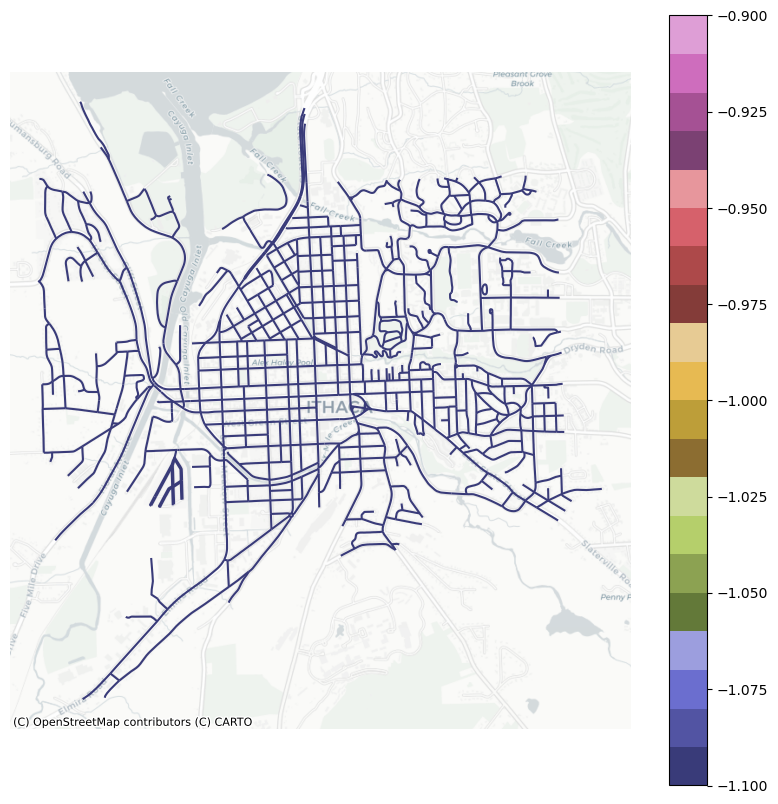

In [136]:
import matplotlib.pyplot as plt
import contextily as ctx

# Minimal safe plotting
gdf_plot = gdf[~gdf.geometry.is_empty & gdf.geometry.is_valid].to_crs(epsg=3857).copy()
gdf_plot['zone'] = gdf_plot['zone'].fillna(-1).astype(int)  # ensure no missing values

fig, ax = plt.subplots(figsize=(10, 10))
gdf_plot.plot(ax=ax, column='zone', cmap='tab20b', linewidth=1.5, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.show()

In [113]:
len(list(nx.connected_components(G)))

149

In [107]:
components = list(nx.connected_components(G))
print(f"{len(components)} components found")

150 components found
